## Uso de Pipelines

1. carregar o conjunto de dados das flores "iris" e agregar valores faltantes.

In [1]:
from sklearn.datasets import load_iris
import numpy as np
iris = load_iris()
iris_data = iris.data
mask = np.random.binomial(1, .25, iris_data.shape).astype(bool)
iris_data[mask] = np.nan
iris_data[:5]

array([[5.1, 3.5, nan, 0.2],
       [4.9, 3. , 1.4, nan],
       [4.7, 3.2, nan, 0.2],
       [nan, 3.1, 1.5, nan],
       [5. , 3.6, nan, 0.2]])

## Como fazer

O propósito vai ser atribuir valores faltantes no conjunto de dado para depois fazer um PCA no conjunto de dados correto. 
E pipelines vai facilitar muito.

1. Carregar as bibliotecas

In [2]:
from sklearn import pipeline, preprocessing, decomposition
from sklearn.impute import SimpleImputer

2. criar classes *'imputer'* (atribuidor de valores) e *PCA*

In [3]:
pca = decomposition.PCA()
atribuidor = SimpleImputer()

3. agora que se tem as classes que são precisas, carrega-lo no pipeline (canal)

In [4]:
pipe = pipeline.Pipeline([("imputer", atribuidor),("pca", pca)])
iris_data_transformada = pipe.fit_transform(iris_data)
iris_data_transformada[:5]

array([[-0.59397611, -0.95997718,  0.62802626, -0.2308021 ],
       [-2.33240272,  0.31194045, -0.74989241, -0.14566549],
       [-0.70987584, -1.28862049,  0.31474495, -0.05640128],
       [-1.9405673 ,  0.99488877, -0.26943393, -0.01815987],
       [-0.63392221, -1.03381476,  0.62500881, -0.34457036]])

## Como Funciona

Cada passo no pipeline é enviado para um objeto pipeline em uma lista de tuplas, com o primeiro elemento se obtém o nome e o segundo obtem o objeto atual. Por baixo dos panos, estos passos entram em loop finito quando o método como o "fit_transform" é utilizado como objeto pipeline.

Para adicionar mais potência pode ser usado o `StandarScaler`, mas a função `pipeline` criará automaticamente os nomes para o objeto pipeline

In [5]:
pipe2 = pipeline.make_pipeline(atribuidor, pca)
pipe2.steps

[('simpleimputer', SimpleImputer()), ('pca', PCA())]

In [6]:
iris_data_transformada2 = pipe2.fit_transform(iris_data)
iris_data_transformada2[:5]

array([[-0.59397611, -0.95997718,  0.62802626, -0.2308021 ],
       [-2.33240272,  0.31194045, -0.74989241, -0.14566549],
       [-0.70987584, -1.28862049,  0.31474495, -0.05640128],
       [-1.9405673 ,  0.99488877, -0.26943393, -0.01815987],
       [-0.63392221, -1.03381476,  0.62500881, -0.34457036]])

## Tem mais

Foi visto sobre pipelines num nível elevado, mas é provável que tenha-se que aplicar uma tranformação base. Então os atributos em cada objeto de uma pipeline pode ser acessado usando a função `set_params`, onde o parâmetro segue a convenção `<step_name>__<step_parameter>`. Por exemplo, será mudado o objeto `pca`  para usar dois componentes:

In [7]:
pipe2.set_params(pca__n_components=2)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('pca', PCA(n_components=2))])

Olhe que o `n_components=2` na saída. Só como teste, podemos produzir, a mesma transformação  que tenha feito duas vezes, e a saída será uma matriz **Nx2**

In [8]:
iris_data_transformada3 = pipe2.fit_transform(iris_data)
iris_data_transformada3[:5]

array([[-0.59397611, -0.95997718],
       [-2.33240272,  0.31194045],
       [-0.70987584, -1.28862049],
       [-1.9405673 ,  0.99488877],
       [-0.63392221, -1.03381476]])

In [9]:
iris_data_transformada3[:5].shape

(5, 2)

In [10]:
iris_data[:5].shape

(5, 4)

## Usando processos Gaussianos para regressão


Com o processo Gaussiano, é sobre variação e não a média. Mesmo assim o processo Gaussiano, será assumido que a média é zero. Os passos são similares aos anteiores, colocar os coeficientes em um problema de regressão típico. Com o processo Gaussiano será os dados antes colocado em uma forma funcional, e sua covariancia entre os pontos de dados que é utilizado para modelar os dados, para assim fazer ajustes.

Uma grande vantagem nestes processos é que eles podem preveer probabilidades,e pode confiar nas previsões. Uma desvantagem do processos Gaussianos é a falta de eficiencia em espaços de grandes dimensões.

In [11]:
# importando load_boston from datasets, mas este foi removido, então foi abaixado dessa url
import pandas as pd
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url,sep='\s+',skiprows=22, header=None)
boston_x = np.hstack([raw_df.values[::2,:],raw_df.values[1::2,:2]])
boston_y= raw_df.values[1::2,2]

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_38145/721260086.py:4: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url,sep='\s+',skiprows=22, header=None)


In [12]:
train_set = np.random.choice([True, False],len(boston_y),p=[.75,.25])

## Como fazer

1. criar um um objeto `GaussianProcessRegresso` como scikit-learn

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [14]:
gpr = GaussianProcessRegressor()

In [15]:
print(gpr)

GaussianProcessRegressor()


Há alguns parâmetros dentro do GaussianProcessRegressor para ajustar

- `alpha`
- `kernel` é uma função que aproximações, a função padrão é (RBF  radial basis functions), serve para construir um núcleo flexivel a partir de núcleos constantes e núcleos RBF
- `normalize_y` ajustar para "True" se a média do conjunto alvo não é zero.
- `n_restarts_optimizer` 10-20 para usos práticos, é o número de iterações para otimizar os núcleos.

2. Importar a função kernel e configurar para kernel flexível

In [16]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as CK

In [17]:
nucleo_misturado = kernel = CK(1.0, (1e-4,1e4)) * RBF(10, (1e-4, 1e4))

3. Instancia e alimentar o algoritmo. Com alpha=5 para todos os valores

In [18]:
gpr =  GaussianProcessRegressor(alpha=5,
                                n_restarts_optimizer=20,
                                kernel = nucleo_misturado)
gpr

GaussianProcessRegressor(alpha=5, kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=20)

In [19]:
gpr.fit(boston_x[train_set], boston_y[train_set])

/home/io/anaconda3/envs/notebook/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=5, kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=20)

4. armazenar as previsões sobre dados não visto como `test_preds`

In [20]:
test_preds = gpr.predict(boston_x[~train_set])

5. plotar os resultados

In [21]:
from sklearn.model_selection import cross_val_predict

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

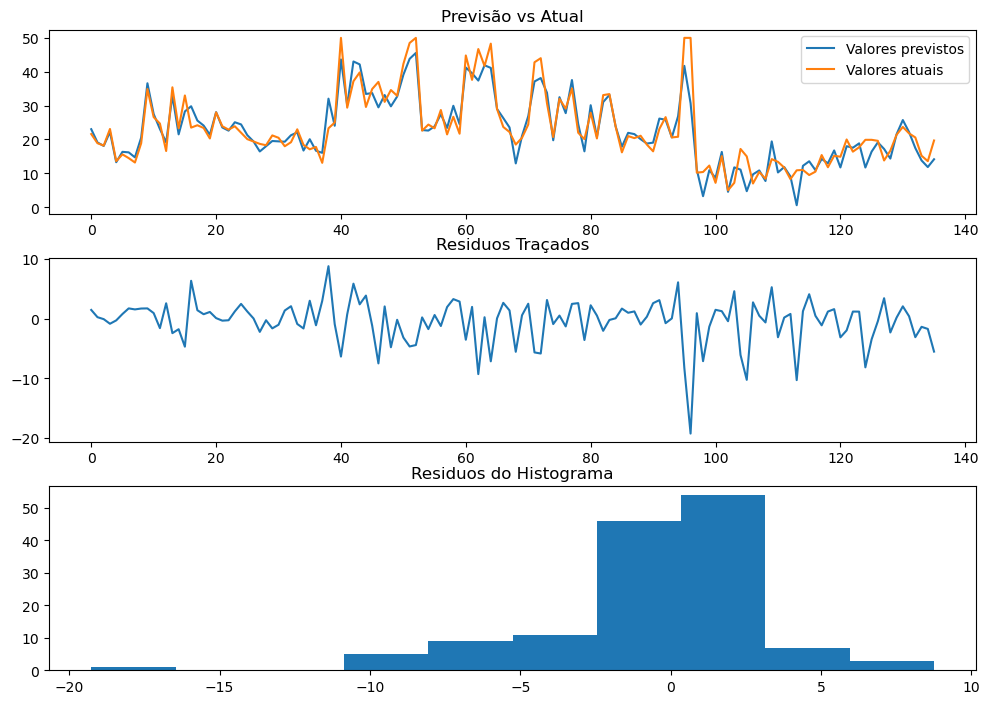

In [23]:
f, ax = plt.subplots(figsize=(10,7), nrows=3)
f.tight_layout()
ax[0].plot(range(len(test_preds)), test_preds, label="Valores previstos")
ax[0].plot(range(len(test_preds)), boston_y[~train_set], label="Valores atuais")
ax[0].set_title("Previsão vs Atual")
ax[0].legend(loc='best')

ax[1].plot(range(len(test_preds)), test_preds - boston_y[~train_set])
ax[1].set_title("Residuos Traçados")
ax[2].hist(test_preds - boston_y[~train_set])
ax[2].set_title("Residuos do Histograma")
plt.show()

## Cros validation com parametros de ruído

1. avaliar o cross-validation com `alpha=5`

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
gpr5 = GaussianProcessRegressor(alpha=5,
                                n_restarts_optimizer=20,
                                kernel= nucleo_misturado)

In [26]:
scores_5 = (cross_val_score(gpr5,
                           boston_x[train_set],
                           boston_y[train_set],
                           cv=4,
                           scoring='neg_mean_absolute_error'))

/home/io/anaconda3/envs/notebook/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/io/anaconda3/envs/notebook/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/io/anaconda3/envs/notebook/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/io/anaconda3/

2. olhar as pontuações no `scores_5`

In [27]:
def score_mini_report(scores_list):
    print(f"Lista de pontuações: {scores_list}")
    print(f"Média das pontuações: {scores_list.mean()}")
    print(f"Erro padrão das pontuações: {scores_list.std()}")

In [28]:
score_mini_report(scores_5)

Lista de pontuações: [ -3.26177216  -4.58372218  -3.5418874  -14.352881  ]
Média das pontuações: -6.435065684139884
Erro padrão das pontuações: 4.597813187975595


3. faça um reporte com `alpha=7`

In [29]:
gpr7 = GaussianProcessRegressor(alpha=7,
                                n_restarts_optimizer=20,
                                kernel= nucleo_misturado)

In [30]:
scores_7 = (cross_val_score(gpr7, boston_x[train_set], boston_y[train_set],
                            cv=4, scoring='neg_mean_absolute_error'))

/home/io/anaconda3/envs/notebook/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/io/anaconda3/envs/notebook/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/io/anaconda3/envs/notebook/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/io/anaconda3/

In [31]:
score_mini_report(scores_7)

Lista de pontuações: [ -3.02850831  -4.06677326  -3.68147587 -12.18518053]
Média das pontuações: -5.740484492336021
Erro padrão das pontuações: 3.7393096840241085


4. A pontuação é um pouco melhor com `alpha=7` e `normalize_y` configurado para `True`

In [32]:
#from sklearn.model_selection import cross_val_score
gpr7n = GaussianProcessRegressor(alpha=7, n_restarts_optimizer=20,
                                 kernel= nucleo_misturado, normalize_y=True)

In [33]:
scores_7n = (cross_val_score(gpr7n, boston_x[train_set], boston_y[train_set],
                            cv=4, scoring='neg_mean_absolute_error'))
scores_7n

/home/io/anaconda3/envs/notebook/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


array([-5.14928164, -6.36007045, -6.5828    , -9.65049904])

In [34]:
score_mini_report(scores_7n)

Lista de pontuações: [-5.14928164 -6.36007045 -6.5828     -9.65049904]
Média das pontuações: -6.9356627842025595
Erro padrão das pontuações: 1.6596168369855644


5. selecionar o melhor modelo para o último treinamento

In [35]:
gpr7n.fit(boston_x[train_set], boston_y[train_set])

GaussianProcessRegressor(alpha=7, kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=20, normalize_y=True)

6. previsão

In [36]:
test_preds = gpr7n.predict(boston_x[~train_set])

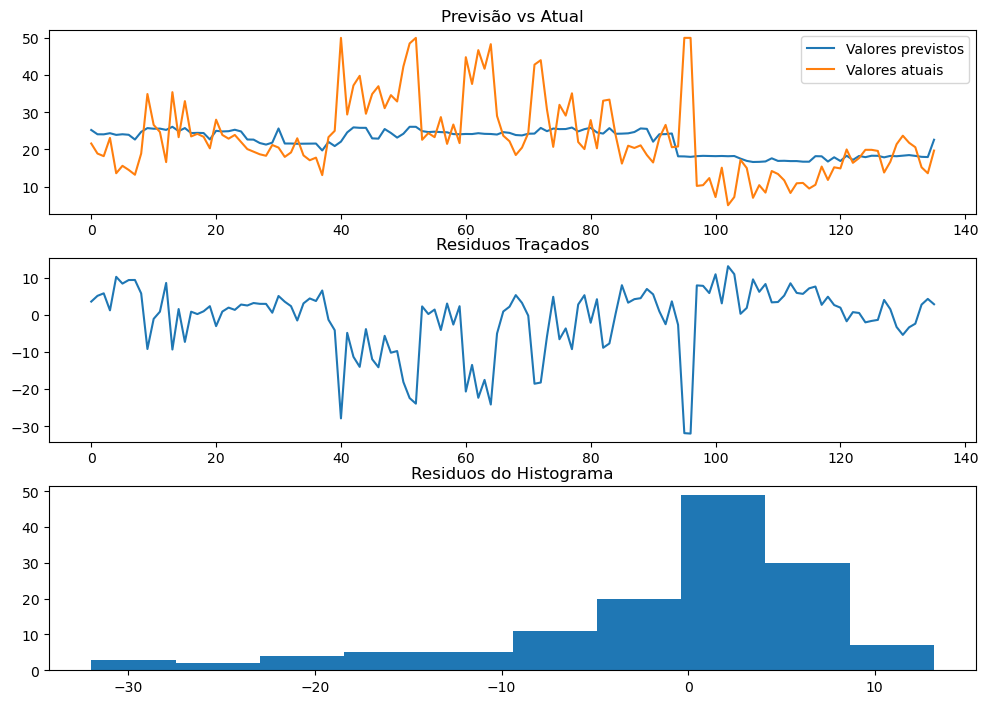

In [37]:
f, ax = plt.subplots(figsize=(10,7), nrows=3)
f.tight_layout()
ax[0].plot(range(len(test_preds)), test_preds, label="Valores previstos")
ax[0].plot(range(len(test_preds)), boston_y[~train_set], label="Valores atuais")
ax[0].set_title("Previsão vs Atual")
ax[0].legend(loc='best')

ax[1].plot(range(len(test_preds)), test_preds - boston_y[~train_set])
ax[1].set_title("Residuos Traçados")
ax[2].hist(test_preds - boston_y[~train_set])
ax[2].set_title("Residuos do Histograma")
plt.show()

In [38]:
gpr_new = GaussianProcessRegressor(alpha=boston_y[train_set]/4,
                                   n_restarts_optimizer=20,
                                   kernel= nucleo_misturado)
gpr_new

GaussianProcessRegressor(alpha=array([ 6.   ,  8.675,  8.35 ,  9.05 ,  7.175,  5.725,  6.775,  4.125,
        3.75 ,  4.725,  5.425,  5.1  ,  4.975,  4.375,  5.05 ,  4.55 ,
        4.9  ,  3.8  ,  3.625,  3.475,  4.15 ,  3.7  ,  4.6  ,  5.25 ,
        3.175,  3.275,  3.375,  5.   ,  5.25 ,  6.175,  7.7  ,  6.325,
        5.3  ,  4.825,  5.   ,  3.6  ,  4.85 ,  4.925,  5.125,  6.25 ,
        5.85 ,  4.725,  6.175,  7.9  ,  4.9  ,  4.675,  4.   ,  5.55 ,
        6.25 ,  4.85 ,  5.5  ,  4.35 ,  5.225,  5.425,  5.7  ,  6.025,
        5.35 ,  5.   ,  5.2  ,  5.3  ,  6.2  ,  6.65 ,  5....
        5.2  ,  2.55 ,  3.625,  3.525,  4.025,  3.575,  2.925,  3.35 ,
        2.4  ,  2.175,  2.1  ,  3.2  ,  4.275,  4.6  ,  2.7  ,  3.725,
        3.15 ,  3.525,  3.25 ,  3.35 ,  4.025,  4.45 ,  3.525,  3.175,
        3.375,  3.725,  4.875,  5.05 ,  5.35 ,  4.75 ,  4.775,  4.775,
        5.025,  5.8  ,  7.45 ,  3.325,  3.   ,  3.65 ,  5.75 ,  6.25 ,
        5.3  ,  4.775,  5.15 ,  1.75 ,  2.025,  5.025,  5.45 ,  6.125,
        5.775,  4.575,  5.3  ,  4.375,  4.2  ,  5.6  ,  5.15 ,  5.975,
        5.5  ,  2.975]),
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=20)

## Mais
É preciso entender a incerteza nas estimativas. Se passar o  argumento `eval_MSE` como verdadeiro.

In [39]:
test_preds, MSE = gpr7n.predict(boston_x[~train_set], return_std=True)
MSE[:5]

array([1.65494544, 1.44696483, 1.45536836, 1.49643536, 1.52168523])

Plotar todas as previsões como barras de erros :

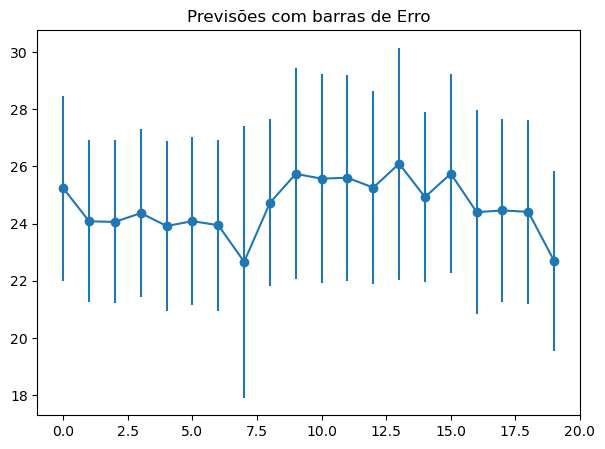

In [40]:
f,ax = plt.subplots(figsize=(7,5))
n = 20
rng = range(n)
ax.scatter(rng, test_preds[:n])
ax.errorbar(rng, test_preds[:n], yerr=1.96*MSE[:n])
ax.set_title("Previsões com barras de Erro")
ax.set_xlim((-1,n))
plt.show()

## Uso de SGD para regressão

1. SGD é bom em grandes conjuntos de dados, bora testar num conjunto grande

In [41]:
from sklearn.datasets import make_regression
X, y = make_regression(int(1e6))  #vai criar um milhão de linhas 

In [51]:
X.shape

(1000000, 100)

2. Essa opção vai depender de sistema para sistema..

In [42]:
print(f"{X.nbytes:,}")

800,000,000


3. Converter `nbytes` para megabytes. (1milhão de bytes=1megabyte)

In [43]:
X.nbytes / 1e6

800.0

4. Quantos bytes por cada dado.... (é bom conhecer como obter o tamanho dos objetos que está usando)

In [44]:
X.nbytes / (X.shape[0] * X.shape[1])

8.0

5. ajustar o SGDRegressor

In [45]:
from sklearn.linear_model import SGDRegressor

In [46]:
sgd = SGDRegressor()

In [47]:
train = np.random.choice([True, False], size=len(y), p=[.75,.25])
sgd.fit(X[train], y[train])

SGDRegressor()

A primeira coisa à saber é que a função de perda é "squared_loss" (perda ao quadrado), que algo similar que acontece na regressão linear. Também é bom saber que  embaralhar gerará um ordem aleatória de dados.

6. Preveer usando API do scikit-learn

In [48]:
y_pred = sgd.predict(X[~train])

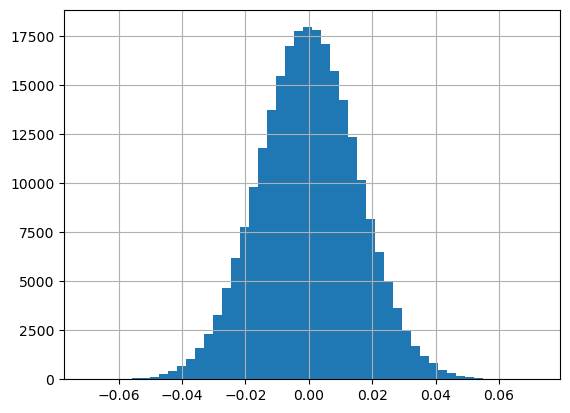

In [49]:
%matplotlib inline
import pandas as pd

pd.Series(y[~train] - y_pred).hist(bins=50)
plt.show()

## Como funciona

É um conjunto fake mas foi bom, mas essa é a abordagem para grandes conjuntos de dados. Conjuntos grandes são como os dados na bolsa americana que pode alcançar a dois bilhões de transações em um dia, imagine em uma semana, ou um ano, 'rodar' na algoritmo puro, não funciona com grandes quantidades de dados. (Para isso, precisa-se conhecimento de calculo 3 na faculdade.)
